<a href="https://colab.research.google.com/github/harrisuddin/F20DL/blob/main/F20DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [94]:
import sys
assert sys.version_info >= (3, 5)
# Python ≥3.5 is required


In [95]:
# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

In [96]:
# Common imports
import numpy as np
import os
import tarfile
import urllib
import pandas as pd
import requests
import io
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold


In [97]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Get the data

In [98]:
raw_data_url = "https://raw.githubusercontent.com/harrisuddin/F20DL/main/Airbnb_Open_Data.csv"
def load_bnb_data(url=raw_data_url):
  # download the csv file from github
  download = requests.get(url).content

  # read the downloaded content and put into dataframe
  df = pd.read_csv(io.StringIO(download.decode("utf-8")),index_col=0,infer_datetime_format=True,dayfirst=False,dtype={'id':'int','instant_bookable':'string','cancellation_policy':'string','room type':'string','Construction year':'float','NAME':'string','host id':'int','host_identity_verified':'string' ,'host name':'string','neighbourhood group':'string','neighbourhood':'string','lat':'float','long':'float','country':'string','country code':'string', 	'...':'string','service fee':'string','minimum nights':'float','number of reviews':'float', 'last review':'object','reviews per month':'float','review rate number':'float','calculated host listings count':'float','availability 365':'float','house_rules':'string','license':'string'
})
  return df

In [99]:
bnb_data = load_bnb_data()

In [100]:
#Filters the bnb df to only contain values that makes sense in the context of a year such as availability and minimum nights as neither can go above 365 or below 0
bnb_data=bnb_data[(bnb_data['availability 365']>=0)&(bnb_data['availability 365']<=365)&(bnb_data['minimum nights']<=365)&(bnb_data['minimum nights']>=0)]


In [101]:
#This method prints information about a DataFrame including the dtype and columns, non-null values and memory usage.
#changing the 2 prices to ints for better analysis
bnb_data[bnb_data.columns[14]] = bnb_data[bnb_data.columns[14]].replace('[\$,]', '', regex=True).astype(float)
bnb_data[bnb_data.columns[15]] = bnb_data[bnb_data.columns[15]].replace('[\$,]', '', regex=True).astype(float)
bnb_data[bnb_data.columns[16]] = bnb_data[bnb_data.columns[16]].replace('[\$,]', '', regex=True).astype(float)

bnb_data['host_identity_verified']=bnb_data['host_identity_verified'].fillna('unconfirmed')
bnb_data['country']=bnb_data['country'].fillna('United States')
bnb_data['country code']=bnb_data['country code'].fillna('US')
bnb_data['instant_bookable']=bnb_data['instant_bookable'].fillna('FALSE')
bnb_data['cancellation_policy']=bnb_data['cancellation_policy'].fillna('strict')
bnb_data['room type']=bnb_data['room type'].fillna('Entire home/apt') #filling in with most common entry
bnb_data['price']=bnb_data['price'].fillna(np.mean(bnb_data['price']))
bnb_data['service fee']=bnb_data['service fee'].fillna(np.mean(bnb_data['service fee'])) #filling in with mean of service fee
bnb_data['minimum nights']=bnb_data['minimum nights'].fillna(np.mean(bnb_data['minimum nights']))
bnb_data['number of reviews']=bnb_data['number of reviews'].fillna(0)
bnb_data['reviews per month']=bnb_data['reviews per month'].fillna(0)
bnb_data['review rate number']=bnb_data['review rate number'].fillna(0)
bnb_data['availability 365']=bnb_data['availability 365'].fillna(np.mean(bnb_data['availability 365']))
bnb_data['house_rules']=bnb_data['house_rules'].fillna('unspecified')
bnb_data['license']=bnb_data['license'].fillna('unspecified')

bnb_data.info() 
#bnb_data.describe()
#Q2 Can you tell if there are any missing values? If yes, which attributes contain missing values ? 
#bnb_data.info() is used to find how many instances have missing values by comparing entry count and Non-Null values 
#most incomplete attribute is license, house rules, reviews per month and review rate number. 
#However in this case a null value could mean no reviews were done rather than the data being missing

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98527 entries, 1001254 to 6094647
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   NAME                            98312 non-null  string 
 1   host id                         98527 non-null  int64  
 2   host_identity_verified          98527 non-null  string 
 3   host name                       98141 non-null  string 
 4   neighbourhood group             98511 non-null  string 
 5   neighbourhood                   98515 non-null  string 
 6   lat                             98519 non-null  float64
 7   long                            98519 non-null  float64
 8   country                         98527 non-null  string 
 9   country code                    98527 non-null  string 
 10  instant_bookable                98527 non-null  string 
 11  cancellation_policy             98527 non-null  string 
 12  room type               

In [102]:
bnb_data.head()

,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,...,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
id,,,,,,,,,,,,,,,,,,,,,
1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,...,193.0,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,unspecified
1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,...,28.0,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,unspecified
1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,unconfirmed,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,US,...,124.0,3.0,0.0,NaN,0.00,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",unspecified
1002755,<NA>,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,...,74.0,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,unspecified,unspecified
1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,...,41.0,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",unspecified


In [103]:
bnb_data["lat"].value_counts()
# Q3 What does the value_count() method display?
# Returns the count of unique values in the dataset

40.76411    36
40.71813    31
40.76125    28
40.73756    27
40.76106    25
            ..
40.62598     1
40.77674     1
40.73647     1
40.82856     1
40.78423     1
Name: lat, Length: 21748, dtype: int64

In [104]:
# This method shows a statistical summary of the numerical attributes 
bnb_data.describe() 

,host id,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,9.852700e+04,98519.000000,98519.000000,98361.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98237.000000,98527.000000
mean,4.923672e+10,40.727974,-73.949330,2012.489767,625.789851,125.129303,7.886001,27.117450,1.177504,3.278076,8.058624,134.460737
std,2.854289e+10,0.055977,0.049888,5.764003,331.324105,66.248412,17.056816,48.837168,1.691388,1.289284,32.631483,129.802427
min,1.236005e+08,40.499790,-74.249840,2003.000000,50.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,2.455850e+10,40.688690,-73.982520,2008.000000,341.000000,68.000000,2.000000,1.000000,0.090000,2.000000,1.000000,2.000000
50%,4.910042e+10,40.722160,-73.954320,2012.000000,625.789851,125.000000,3.000000,7.000000,0.490000,3.000000,1.000000,90.000000
75%,7.396972e+10,40.762680,-73.931900,2018.000000,913.000000,183.000000,5.000000,30.000000,1.740000,4.000000,2.000000,254.000000
max,9.876313e+10,40.916970,-73.705220,2022.000000,1200.000000,240.000000,365.000000,1024.000000,90.000000,5.000000,332.000000,365.000000


The count, mean, min, and max rows are self-explanatory. Note that the null values are ignored.

The 25%, 50%, and 75% rows show the corresponding percentiles: a percentile indicates the value below which a given percentage of observations in a group of observations fall.

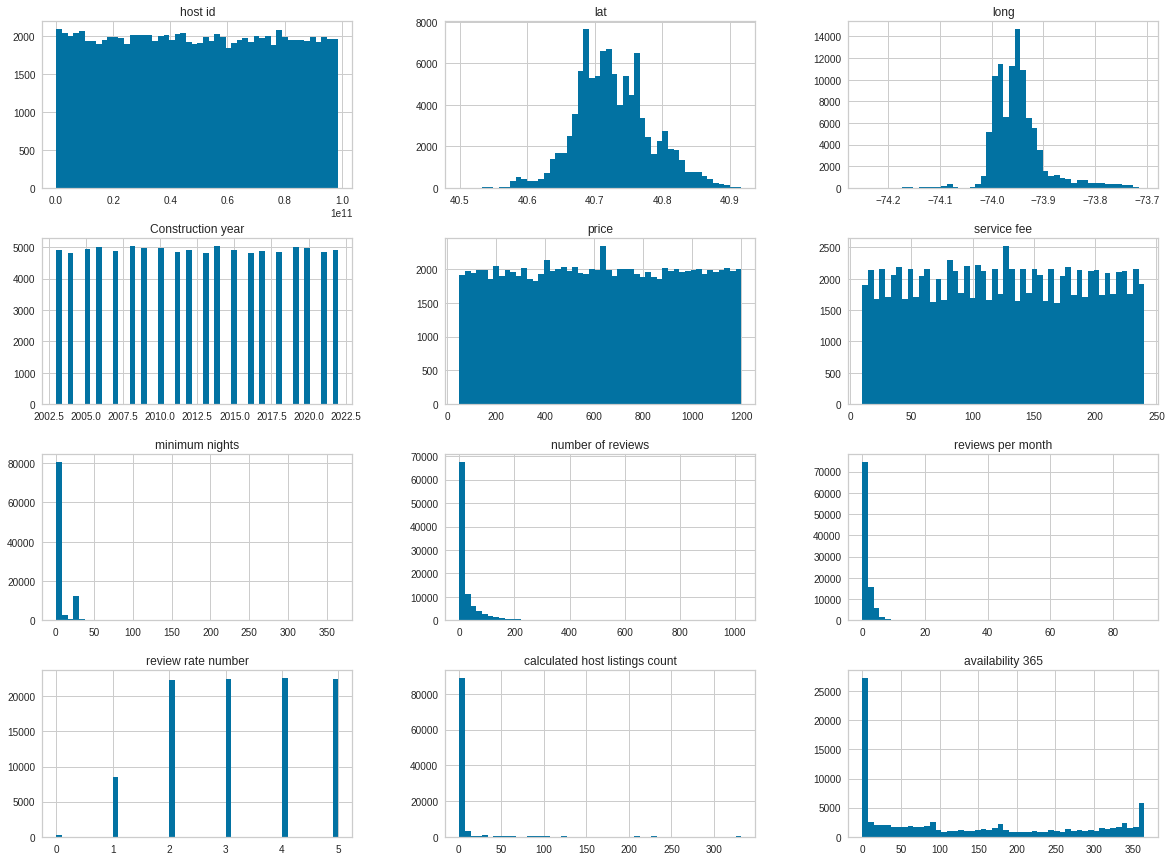

In [105]:
# To plot a histogram for each numerical attribute
bnb_data.hist(bins=50, figsize=(20,15))
plt.show()
# Q4 List down the main observations you noted from the statistical summary and the histogram

#- host id is pointless to show like this
#- This is also true for some of the data statistics in such as construction year's std and mean do not provide a lot of insight or meaning
#- Max availability is 3677 which cannot be true in a 365 day/year same can be said for minimum nights at >365 or <0(before removing those values in line 11)
#- an near-equal number of 2, 3, 4, 5 star reviews which is annoying
#- same with construction year

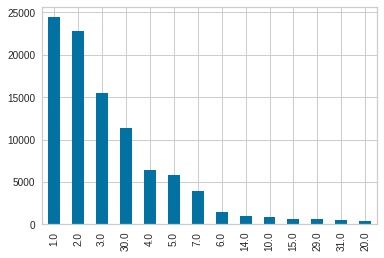

In [106]:
# Q5 Now you will plot 3 different variations of the data, which one is more indicative and why?

# plotting the frequency of minimum required overnight stays per property
bnb_data['minimum nights'].value_counts()[:20].plot.bar()

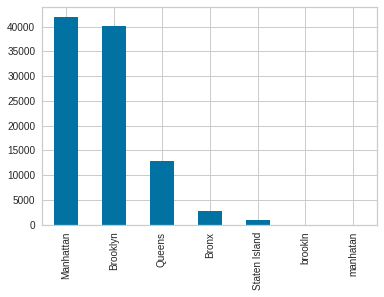

In [107]:
# plotting the frequency of property neighbourhoods
bnb_data['neighbourhood group'].value_counts()[:20].plot.bar()

# those like 5 or so undercapitalised ones lol
# includes typos

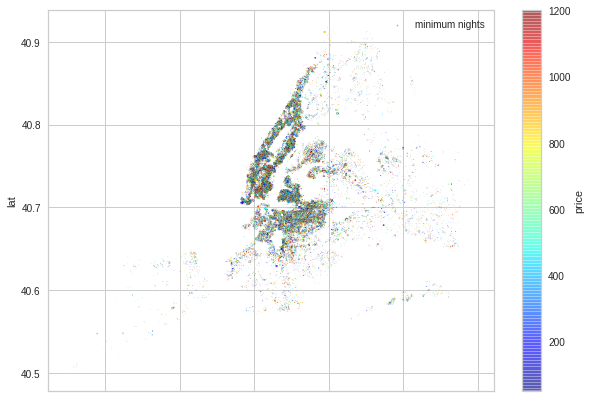

In [108]:
bnb_data.plot(kind="scatter", x="long", y="lat", alpha=0.4,
    s=bnb_data["minimum nights"]/100, label="minimum nights", figsize=(10,7),
    c="price", cmap=plt.get_cmap("jet"), colorbar=True,
)
plt.legend()
#EXAMPLE plots California housing prices:red is expensive, blue is cheap. Large circles indicate areas with larger populations.
#EXAMPLE The radius of each circle represents the district’s population(option s) and the color represents the price (option c).
# plots the price of a property against its longitude and latitude 

In [109]:
# Now we will look at the correlation of all the attributes with the expected class attribute (median-house-value)
corr_matrix = bnb_data.corr() # computes the standard correlation coefficient (Pearson’s r) between every pair of attributes

In [110]:
corr_matrix["price"].sort_values(ascending=False)
# Q6 Which are the most correlated attributes with the output variable(i.e.median house value)?
# Does that make sense? 

price                             1.000000
service fee                       0.997834
number of reviews                 0.005935
reviews per month                 0.005707
host id                           0.003555
long                              0.001548
calculated host listings count   -0.000598
availability 365                 -0.002108
Construction year                -0.004528
lat                              -0.005696
review rate number               -0.005795
minimum nights                   -0.005983
Name: price, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb70fc23890>,
      dtype=object)

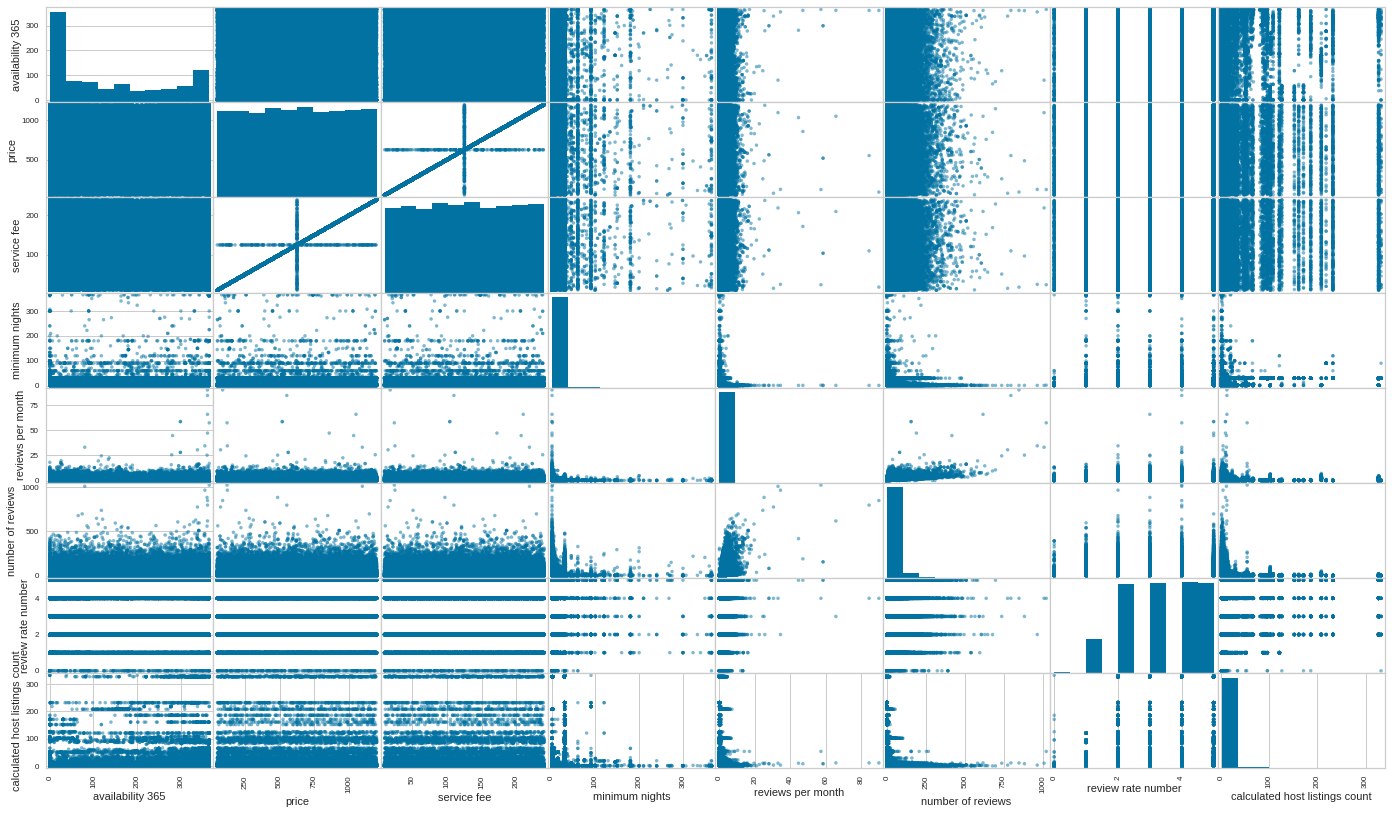

In [111]:
from pandas.plotting import scatter_matrix

attributes = ["availability 365","price", "service fee",'minimum nights',
              'reviews per month','number of reviews',
              'review rate number','calculated host listings count']
scatter_matrix(bnb_data[attributes], figsize=(24, 14))
# Another way to check for correlation between attributes is to use the pandas scatter_matrix() function above
# Here we choose to plot 4 promising  numerical attributes against each other

(0.0, 1250.0, 0.0, 275.0)

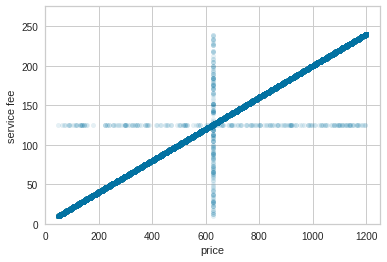

In [112]:
# let’s zoom in on the correlation scatterplot "median house value & the median income,"
bnb_data.plot(kind="scatter", x="price", y="service fee",
             alpha=0.1)
plt.axis([0, 1250, 0, 275])
#Q7 Describe the plot below. What does this indicate? Do you have an explanation for the solid line?
#theres a direct correlation between a bnb's price and its service fee
#bnb's price may include the service fee as a sum

# Experimenting with Attribute Combinations

In [113]:
# Here you will generate new features. This is what we call feature engineering
# Q8 What are the new features that you are generating? Do they make sense ?

bnb_data["minimum stay cost per night"] = bnb_data["price"]/bnb_data["minimum nights"]
#others are from the example

#bnb_data["bedrooms_per_room"] = bnb_data["total_bedrooms"]/bnb_data["total_rooms"]
#bnb_data["population_per_household"]=bnb_data["population"]/bnb_data["households"]

In [114]:
corr_matrix = bnb_data.corr()
corr_matrix["minimum stay cost per night"].sort_values(ascending=False)
# Now you are checking the correlations given the new features 
# Q9 Did you get better features ?

minimum stay cost per night       1.000000
price                             0.529871
service fee                       0.528872
reviews per month                 0.224972
number of reviews                 0.112483
long                              0.094758
Construction year                 0.004410
host id                           0.001699
review rate number               -0.004833
lat                              -0.010376
availability 365                 -0.012369
calculated host listings count   -0.100044
minimum nights                   -0.334932
Name: minimum stay cost per night, dtype: float64

In [115]:
#Q10 Plot the scatter plot of the rooms_per_household against median_house_value
#Q11 Now use the housing describe method to view the statistical summary of the dataset 

In [116]:
# y = bnb_data["price"]
# y = y.dropna(how='any',axis=0)
X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night"])
X.describe()

,lat,long,Construction year,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365
count,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000,98067.000000
mean,40.727966,-73.949324,2012.490114,125.138702,7.893450,27.063406,1.177419,3.281552,8.067189,134.437425
std,0.055959,0.049925,5.762923,66.245045,17.047806,48.786374,1.692493,1.286285,32.656941,129.831508
min,40.499790,-74.249840,2003.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,40.688690,-73.982530,2008.000000,68.000000,2.000000,1.000000,0.090000,2.000000,1.000000,2.000000
50%,40.722170,-73.954320,2012.000000,125.000000,3.000000,7.000000,0.490000,3.000000,1.000000,90.000000
75%,40.762660,-73.931870,2017.000000,183.000000,5.000000,30.000000,1.740000,4.000000,2.000000,254.000000
max,40.916970,-73.705220,2022.000000,240.000000,365.000000,1024.000000,90.000000,5.000000,332.000000,365.000000


In [117]:
from sklearn.linear_model import SGDClassifier, SGDRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)
y_train_above_mean = (y_train > 626.110441)
y_test_above_mean = (y_test > 626.110441)
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_above_mean)

SGDClassifier(random_state=42)

In [118]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_above_mean, cv=3)

<img src="https://miro.medium.com/max/1051/1*fxiTNIgOyvAombPJx5KGeA.png" alt="Confusion Matrix" style="width: 400px;"/>

In [119]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_above_mean, y_train_pred)

array([[23524,  1179],
       [  411, 23919]])

In [120]:
y_train_perfect_predictions = y_train_above_mean  # pretend we reached perfection
confusion_matrix(y_train_above_mean, y_train_perfect_predictions)

array([[24703,     0],
       [    0, 24330]])

In [121]:
from sklearn.metrics import precision_score, recall_score

# Precision is the number of correctly classified positive examples divided by the total number of examples that are classified as positive. 
precision_score(y_train_above_mean, y_train_pred)

0.9530241453502271

In [122]:
# Recall r is the number of correctly classified positive examples divided by the total number of actual positive examples in the test set. 
recall_score(y_train_above_mean, y_train_pred)

0.9831072749691738

In [123]:
from sklearn.metrics import f1_score
# f1 score (or f-measure) combines the recall and precision, the higher the better the model
f1_score(y_train_above_mean, y_train_pred)

0.967831998057781

In [124]:
y_scores = sgd_clf.decision_function(X_train.iloc[[1]])
y_scores

array([-139611.06750274])

In [125]:
threshold = 0
y_some_row_pred = (y_scores > threshold)

In [126]:
y_some_row_pred

array([False])

In [127]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [128]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_above_mean, cv=3,
                             method="decision_function")

In [129]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_above_mean, y_scores)

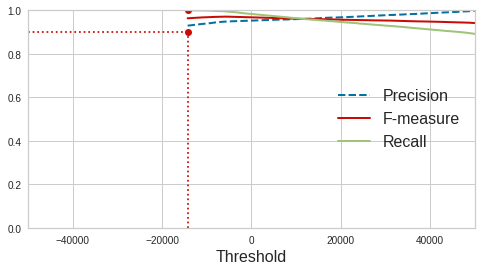

In [130]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, (2*recalls[:-1]*precisions[:-1])/(recalls[:-1]+precisions[:-1]), "r-", label="F-measure", linewidth=2) #F-measure
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
plt.show()

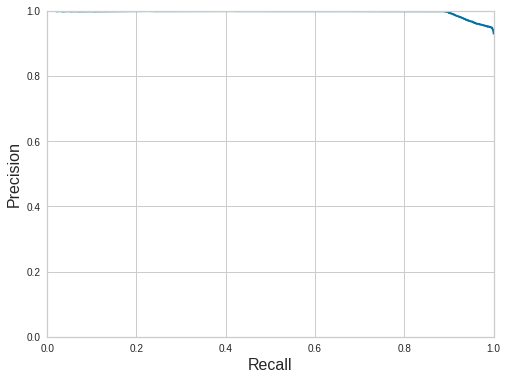

In [131]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
# plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
# plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
# plt.plot([0.4368], [0.9], "ro")
plt.show()

In [132]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_above_mean, y_scores)

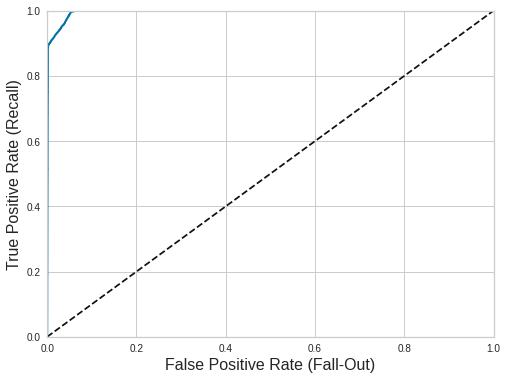

In [133]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
# plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
# plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
# plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
plt.show()

In [134]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_above_mean, y_scores)

0.996144232112931

In [135]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_above_mean, cv=3, scoring="accuracy")

array([0.98745794, 0.92933186, 0.98592756])

In [136]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night"])

x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)

y_trainTTS_above_mean = (y_trainTTS > 625.830539)
y_testTTS_above_mean = (y_testTTS > 625.830539)

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)

sgd_clf.fit(x_trainTTS, y_trainTTS_above_mean)

score = sgd_clf.score(x_trainTTS, y_trainTTS_above_mean)
print("Training score: ", score) 


Training score:  0.9896804193094446


as can be seen from the 2 codeblocks above the cross validation gives a much higher accuracy score than test/train split also more importantly i would argue the cross validation runs much faster than the test train split.

# Pipeline stuff

In [137]:
bnb_data.describe()

,host id,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,minimum stay cost per night
count,9.852700e+04,98519.000000,98519.000000,98361.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98527.000000,98237.000000,98527.000000,98527.000000
mean,4.923672e+10,40.727974,-73.949330,2012.489767,625.789851,125.129303,7.886001,27.117450,1.177504,3.278076,8.058624,134.460737,288.493563
std,2.854289e+10,0.055977,0.049888,5.764003,331.324105,66.248412,17.056816,48.837168,1.691388,1.289284,32.631483,129.802427,288.696453
min,1.236005e+08,40.499790,-74.249840,2003.000000,50.000000,10.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.196226
25%,2.455850e+10,40.688690,-73.982520,2008.000000,341.000000,68.000000,2.000000,1.000000,0.090000,2.000000,1.000000,2.000000,62.250000
50%,4.910042e+10,40.722160,-73.954320,2012.000000,625.789851,125.000000,3.000000,7.000000,0.490000,3.000000,1.000000,90.000000,196.600000
75%,7.396972e+10,40.762680,-73.931900,2018.000000,913.000000,183.000000,5.000000,30.000000,1.740000,4.000000,2.000000,254.000000,408.000000
max,9.876313e+10,40.916970,-73.705220,2022.000000,1200.000000,240.000000,365.000000,1024.000000,90.000000,5.000000,332.000000,365.000000,1200.000000


In [138]:
np.random.seed(42)

In [139]:
def split_train_test(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio) 
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [140]:
train_set, test_set = split_train_test(bnb_data, 0.2)
len(train_set), len(test_set)

(78822, 19705)

In [141]:
bnb_num = bnb_data.select_dtypes(include=['float64'])
bnb_num.head()

,lat,long,Construction year,price,service fee,minimum nights,number of reviews,reviews per month,review rate number,calculated host listings count,availability 365,minimum stay cost per night
id,,,,,,,,,,,,
1001254,40.64749,-73.97237,2020.0,966.0,193.0,10.0,9.0,0.21,4.0,6.0,286.0,96.600000
1002102,40.75362,-73.98377,2007.0,142.0,28.0,30.0,45.0,0.38,4.0,2.0,228.0,4.733333
1002403,40.80902,-73.94190,2005.0,620.0,124.0,3.0,0.0,0.00,5.0,1.0,352.0,206.666667
1002755,40.68514,-73.95976,2005.0,368.0,74.0,30.0,270.0,4.64,4.0,1.0,322.0,12.266667
1003689,40.79851,-73.94399,2009.0,204.0,41.0,10.0,9.0,0.10,3.0,1.0,289.0,20.400000


In [142]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="median")), # Dealing with missing values
    #('attribs_adder', CombinedAttributesAdder()), # New attribute
    ('std_scaler', StandardScaler()),            # Attribute normalization
])

bnb_num_tr = num_pipeline.fit_transform(bnb_num)
bnb_num_tr

array([[-1.43787142, -0.46184399,  1.30419536, ..., -0.06253847,
         1.16746686, -0.66469309],
       [ 0.45818534, -0.69036448, -0.95308184, ..., -0.18529245,
         0.72063166, -0.98290667],
       [ 1.44792947,  0.14894717, -1.30035525, ..., -0.21598094,
         1.67593451, -0.28343719],
       ...,
       [-0.34575845,  0.05653669, -1.64762867, ..., -0.21598094,
         0.7129276 ,  1.92419841],
       [-0.94550051, -0.6238129 , -0.60580842, ..., -0.21598094,
         1.59889396,  0.14146339],
       [ 0.71634062, -0.6833485 , -0.43217171, ..., -0.21598094,
        -0.50431313,  2.57540473]])

In [143]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

#num_attribs = list(bnb_num)

num_attribs = bnb_data.select_dtypes(include=['float64']).columns
cat_attribs = bnb_data.select_dtypes(include=['string']).columns
bnb_data[cat_attribs] = bnb_data[cat_attribs].fillna('unspecified')

# bnb_data['instant_bookable']=bnb_data['instant_bookable'].fillna('unspecified') #need to change to 0 1 system, then add back into data being pipelined
# bnb_data['room type']=bnb_data['room type'].fillna('unspecified') #need to change to numerical system
# bnb_data['cancellation_policy']=bnb_data['cancellation_policy'].fillna('unspecified') #need to change to numerical system

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

bnb_prepped = full_pipeline.fit_transform(bnb_data)
bnb_prepped

<98527x74087 sparse matrix of type '<class 'numpy.float64'>'
	with 2364151 stored elements in Compressed Sparse Row format>

Lab 5. Bayesian Learning and Bayes Nets

In [144]:
from sklearn.naive_bayes import MultinomialNB
# model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(X, Y)

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)

mnb = MultinomialNB()
y_pred = mnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))

Number of mislabeled points out of a total 49034 points : 2339


Number of mislabeled points out of a total 49034 points : 384 accuracy 0
TP =  24410
FP =  240
TN =  24240
FN =  144
Sensitivity =  0.9941353750916347
specificity =  0.9901960784313726
precision =  241.0
recall =  0.9941353750916347
RoC Area = 


<function matplotlib.pyplot.show(*args, **kw)>

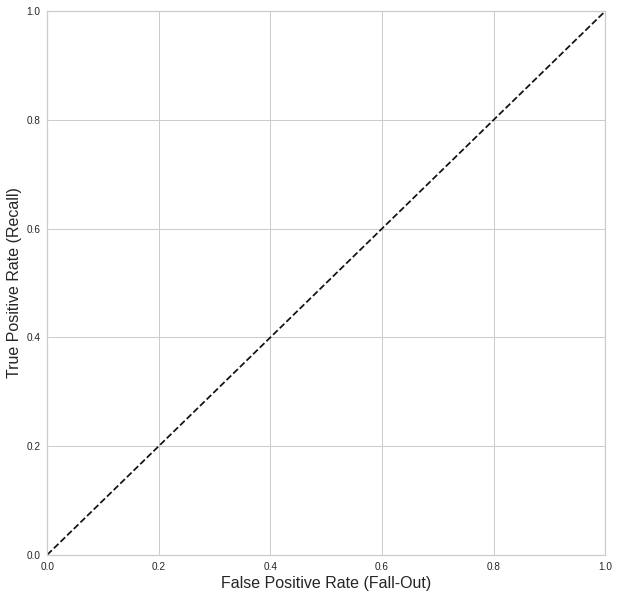

In [145]:
from sklearn.naive_bayes import GaussianNB
# model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(X, Y)

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)

gnb = GaussianNB()
y_pred = gnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d accuracy %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum(), (((y_testTTS_above_mean != y_pred).sum())/(x_testTTS.shape[0])) * 100))

#alpha = (y_testTTS_above_mean != y.pred).sum()
#beta = x_testTTS.shape[0]
#print("Accuracy = ", (alpha / beta *100))

from sklearn.metrics import pair_confusion_matrix
confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show


Bernoulli Naive Bayes
Number of mislabeled points out of a total 49034 points : 24618
Accuracy =  50.20597952441164
TP =  0
FP =  0
TN =  24416
FN =  24618
Sensitivity =  0.0
specificity =  1.0
precision =  nan
recall =  0.0
RoC Area = 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in long_scalars
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: invalid value encountered in long_scalars


<function matplotlib.pyplot.show(*args, **kw)>

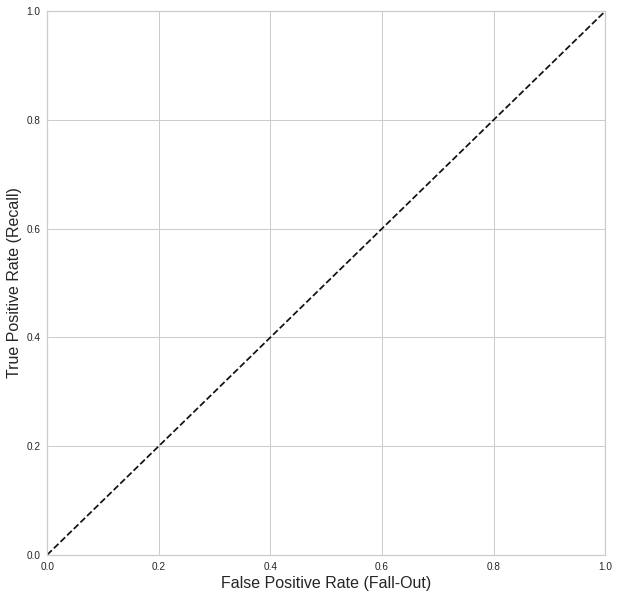

In [146]:
from sklearn.naive_bayes import BernoulliNB
# model = MultinomialNB(alpha=0.0, class_prior=[0.4, 0.6])
# model.fit(X, Y)

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)


bernnb = BernoulliNB(alpha=1.0, binarize=0.0, fit_prior=True, class_prior=[0.4, 0.6])
y_pred = bernnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Bernoulli Naive Bayes")
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))
#alpha = (y_testTTS_above_mean != y.pred).sum()
#beta = x_testTTS.shape[0]
print("Accuracy = ", (((y_testTTS_above_mean != y_pred).sum())/(x_testTTS.shape[0])) * 100)

from sklearn.metrics import pair_confusion_matrix
confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

Bernoulli Naive Bayes
Number of mislabeled points out of a total 49034 points : 2366
Accuracy=  95.17477668556512
TP =  22408
FP =  112
TN =  24260
FN =  2254
Sensitivity =  0.9086043305490228
specificity =  0.9954045626128344
precision =  113.0
recall =  0.9086043305490228
RoC Area = 


<function matplotlib.pyplot.show(*args, **kw)>

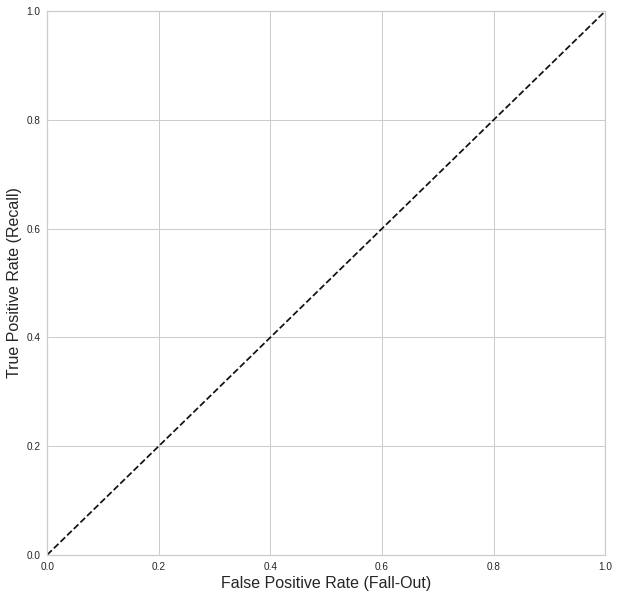

In [147]:
X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])

x_trainTTS.describe()

x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.5)

y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)


from sklearn.naive_bayes import ComplementNB
print("Bernoulli Naive Bayes")


cnb = ComplementNB(alpha=1.0, fit_prior=True, class_prior=[0.4, 0.6], norm=False)
y_pred = cnb.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))

alpha = (y_testTTS_above_mean == y_pred).sum()
beta = x_testTTS.shape[0]
print("Accuracy= ", (alpha / beta * 100))


confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

(58840, 9) (58840,) (39227, 9)
Number of mislabeled points out of a total 39227 points : 115
Accuracy=  99.70683457822417
TP =  19646
FP =  75
TN =  19466
FN =  40
Sensitivity =  0.9979680991567611
specificity =  0.996161915971547
precision =  76.0
recall =  0.9979680991567611
RoC Area =  0.997065007564154


<function matplotlib.pyplot.show(*args, **kw)>

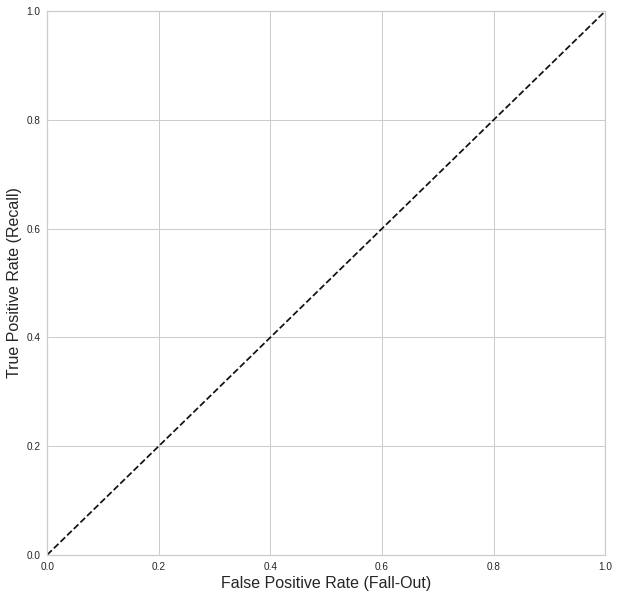

In [148]:
from sklearn.naive_bayes import CategoricalNB
from sklearn.metrics import roc_auc_score

X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night", "long"])
x_trainTTS, x_testTTS, y_trainTTS, y_testTTS = train_test_split(X, y, test_size=0.4)
y_trainTTS_above_mean = (y_trainTTS > 626.110441)
y_testTTS_above_mean = (y_testTTS > 626.110441)

clf = CategoricalNB(min_categories=2)
print(x_trainTTS.shape,y_trainTTS_above_mean.shape,x_testTTS.shape)
y_pred = clf.fit(x_trainTTS, y_trainTTS_above_mean).predict(x_testTTS)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTTS.shape[0], (y_testTTS_above_mean != y_pred).sum()))

alpha = (y_testTTS_above_mean == y_pred).sum()
beta = x_testTTS.shape[0]
print("Accuracy= ", (alpha / beta * 100))

confusion_matrix(y_testTTS_above_mean, y_pred)
matrix = confusion_matrix(y_testTTS_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("Sensitivity = ", matrix[0][0]/(matrix[0][0] + matrix[0][1]))
print("specificity = ", matrix[1][1]/(matrix[1][1] + matrix [1][0]))
print("precision = ", matrix[0][0]/matrix[0][0] + matrix[1][0])
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))

roc_auc_score(y_testTTS_above_mean, y_pred)
print("RoC Area = ",roc_auc_score(y_testTTS_above_mean, y_pred))

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

Clustering


In [149]:
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [150]:
X = bnb_data
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X[["long", "lat"]]
print(X.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83186 entries, 1001254 to 6091885
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   long    83186 non-null  float64
 1   lat     83186 non-null  float64
dtypes: float64(2)
memory usage: 1.9 MB
None


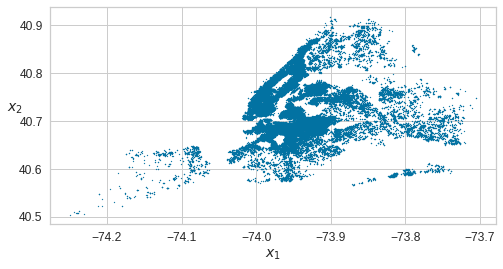

In [151]:
def plot_clusters(X, y=None):
    plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=y, s=1)
    plt.xlabel("$x_1$", fontsize=14)
    plt.ylabel("$x_2$", fontsize=14, rotation=0)

plt.figure(figsize=(8, 4))
plot_clusters(X)
plt.show()

In [152]:
from sklearn.cluster import KMeans

k = 14
kmeans = KMeans(n_clusters=k, random_state=42)
y_pred = kmeans.fit_predict(X)

y_pred

array([ 9, 10,  3, ...,  1, 10,  5], dtype=int32)

In [153]:
y_pred is kmeans.labels_

kmeans.cluster_centers_

array([[-73.83239932,  40.73215627],
       [-73.95104803,  40.71438828],
       [-73.95453879,  40.7916771 ],
       [-73.96757146,  40.6775674 ],
       [-73.7984133 ,  40.59244052],
       [-73.99408224,  40.72360122],
       [-74.10445122,  40.61204201],
       [-73.93811581,  40.83141857],
       [-73.91945244,  40.6855255 ],
       [-73.97339813,  40.63035711],
       [-73.98404373,  40.75702248],
       [-73.86616672,  40.86066522],
       [-73.76660015,  40.68617454],
       [-73.90947795,  40.75582557]])

In [154]:
kmeans.labels_

# X_new = np.array([[0, 2], [3, 2], [-3, 3], [-3, 2.5]])
X_new = np.random.randn(5, 2) * 10
kmeans.predict(X_new)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


array([4, 4, 4, 4, 4], dtype=int32)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


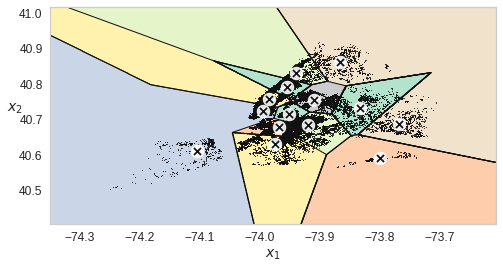

In [155]:
def plot_data(X):
    plt.plot(X.iloc[:, 0], X.iloc[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='k'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=50, linewidths=50,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

plt.figure(figsize=(8, 4))
plot_decision_boundaries(kmeans, X)
plt.show()

In [156]:
kmeans_iter1 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=1, random_state=1)
kmeans_iter2 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=2, random_state=1)
kmeans_iter3 = KMeans(n_clusters=5, init="random", n_init=1,
                     algorithm="full", max_iter=3, random_state=1)
kmeans_iter1.fit(X)
kmeans_iter2.fit(X)
kmeans_iter3.fit(X)

KMeans(algorithm='full', init='random', max_iter=3, n_clusters=5, n_init=1,
       random_state=1)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


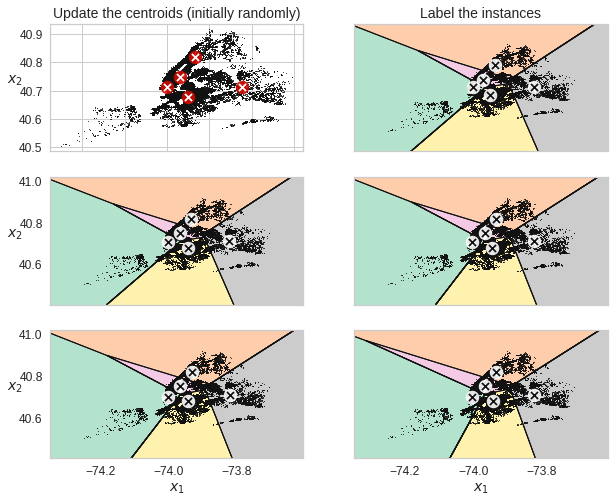

In [157]:
plt.figure(figsize=(10, 8))

plt.subplot(321)
plot_data(X)
plot_centroids(kmeans_iter1.cluster_centers_, circle_color='r', cross_color='w')
plt.ylabel("$x_2$", fontsize=14, rotation=0)
plt.tick_params(labelbottom=False)
plt.title("Update the centroids (initially randomly)", fontsize=14)

plt.subplot(322)
plot_decision_boundaries(kmeans_iter1, X, show_xlabels=False, show_ylabels=False)
plt.title("Label the instances", fontsize=14)

plt.subplot(323)
plot_decision_boundaries(kmeans_iter1, X, show_centroids=False, show_xlabels=False)
plot_centroids(kmeans_iter2.cluster_centers_)

plt.subplot(324)
plot_decision_boundaries(kmeans_iter2, X, show_xlabels=False, show_ylabels=False)

plt.subplot(325)
plot_decision_boundaries(kmeans_iter2, X, show_centroids=False)
plot_centroids(kmeans_iter3.cluster_centers_)

plt.subplot(326)
plot_decision_boundaries(kmeans_iter3, X, show_ylabels=False)

plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


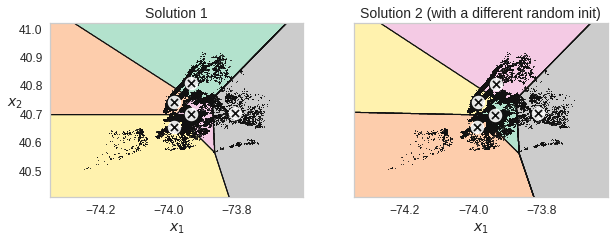

In [158]:
def plot_clusterer_comparison(clusterer1, clusterer2, X, title1=None, title2=None):
    clusterer1.fit(X)
    clusterer2.fit(X)

    plt.figure(figsize=(10, 3.2))

    plt.subplot(121)
    plot_decision_boundaries(clusterer1, X)
    if title1:
        plt.title(title1, fontsize=14)

    plt.subplot(122)
    plot_decision_boundaries(clusterer2, X, show_ylabels=False)
    if title2:
        plt.title(title2, fontsize=14)


kmeans_rnd_init1 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=44)
kmeans_rnd_init2 = KMeans(n_clusters=5, init="random", n_init=1,
                         algorithm="full", random_state=64)

plot_clusterer_comparison(kmeans_rnd_init1, kmeans_rnd_init2, X,
                          "Solution 1", "Solution 2 (with a different random init)")
plt.show()

In [159]:
kmeans.inertia_

37.9724064755287

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  "X does not have valid feature names, but"


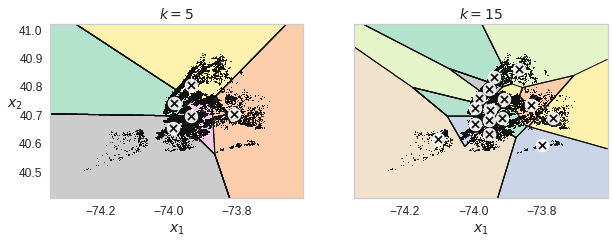

In [160]:
kmeans_k5 = KMeans(n_clusters=5, random_state=42)
kmeans_k15 = KMeans(n_clusters=15, random_state=42)

plot_clusterer_comparison(kmeans_k5, kmeans_k15, X, "$k=5$", "$k=15$")
plt.show()

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/34/5_Boroughs_Labels_New_York_City_Map.svg/450px-5_Boroughs_Labels_New_York_City_Map.svg.png" width="50%"/>

Based on some guesswork we decided to try and use the fact that new york has 5 distinct boroughs and see if they were represented by clusters within the data as can clearly be seen above in the graph where kmeans is set to 5 the graph mathes up fairly closely with the image of the boroughs of new york above. 

Their are ofcourse some inconsistentcys between them like the fact that in the actual map manhattan has a slither extending into the bronx whereas in our clustering graph this is just part of the bronx.
       This is accounted for in the next graph shown above where we used an inertia graph to calculate the optimum number of clusters and created a kmeans graph with 15 clusters the distinct boroughs are gone in this one however some of the unique population centers like long island are better represented.

In [161]:
def plot_inertia(numOfClusters, X):
  xAxis = range(1, numOfClusters)
  yAxis = []
  for i in xAxis:
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X)
    yAxis.append(kmeans.inertia_)
  
  plt.bar(xAxis, yAxis)
  plt.show()

plot_inertia(20, X)

KeyboardInterrupt: ignored

In [ ]:
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,20))
visualizer.fit(X)
visualizer.show()

#runtime is ~55s

The Elbow clustering graph shows much the same data as the one above it where we manually plotted out the inertias for each number of clusters, as well as showing the time taken to compute. This time changes on each run but follows generally the same pattern of increasing with the number of clusters.

In [ ]:
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [3, 5, 7, 9, 11] #range of number of clusters

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        X.iloc[:, 0], X.iloc[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    centers = clusterer.cluster_centers_
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

#runtime is like ~12 mins

Visualising how the clusters are formed can be compared to the image of the NY districts in the image further above.
In the graph with 5 clusters, clusters 2 and 4 most closely resemble the real districts of the Bronx and Manhattan respectively, however cluster 0 has Staten Island combined with half of Brooklyn. This is likely due to less data on the island; if more BNBs were on that area it would likely be its own cluster, as it starts to become an isolated cluster by adding just 1 more cluster.

In [162]:
X = bnb_data.select_dtypes(include=['float64'])
X = X.dropna(how='any',axis=0)
y = X["price"]
X = X.drop(columns=["price", "minimum stay cost per night"])
X.describe()

x_trainTREE, x_testTREE, y_trainTREE, y_testTREE = train_test_split(X, y, test_size=0.5)

y_trainTREE_above_mean = (y_trainTREE > 625.830539)
y_testTREE_above_mean = (y_testTREE > 625.830539)

In [163]:
from sklearn.tree import DecisionTreeClassifier,plot_tree

dtc_clf = DecisionTreeClassifier(max_depth=2, random_state=42)
dtc_clf.fit(x_trainTREE, y_trainTREE_above_mean)


score = dtc_clf.score(x_trainTREE, y_trainTREE_above_mean)
print("Training score: ", score) 


Training score:  0.9956151979279261


Number of mislabeled points out of a total 49034 points : 179
Accuracy=  99.63494717950809
TP =  24475
FP =  78
TN =  24380
FN =  101
precision =  0.9968231987944447
recall =  0.9958902994791666
F-measure =  2.9876708984374996
RoC Area = 


<function matplotlib.pyplot.show(*args, **kw)>

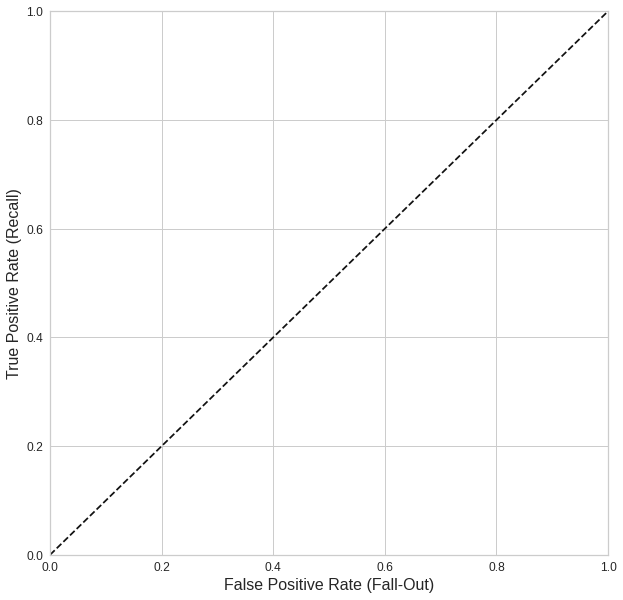

In [164]:
y_pred = dtc_clf.fit(x_trainTREE, y_trainTREE_above_mean).predict(x_testTREE)
print("Number of mislabeled points out of a total %d points : %d" % (x_testTREE.shape[0], (y_testTREE_above_mean != y_pred).sum()))

alpha = (y_testTREE_above_mean == y_pred).sum()
beta = x_testTREE.shape[0]
print("Accuracy= ", (alpha / beta * 100))


confusion_matrix(y_testTREE_above_mean, y_pred)
matrix = confusion_matrix(y_testTREE_above_mean, y_pred)
print("TP = ", matrix[0][0])
print("FP = ", matrix[1][0])
print("TN = ", matrix[1][1])
print("FN = ", matrix[0][1])
print("precision = ", matrix[0][0]/(matrix[0][0] + matrix[1][0]))
print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
print("F-measure = ", (2 * (matrix[0][0]/matrix[0][0] + matrix[1][0]) * (matrix[0][0]/(matrix[0][0] + matrix [0][1])) / (matrix[0][0]/matrix[0][0] + matrix[1][0]) + (matrix[0][0]/(matrix[0][0] + matrix [0][1])) ))
print("RoC Area = ")

plt.figure(figsize=(10,10))
plot_roc_curve((matrix[0][0]/(matrix[0][0] + matrix[0][1])), (matrix[0][0]/matrix[0][0] +matrix[1][0]))
plt.show

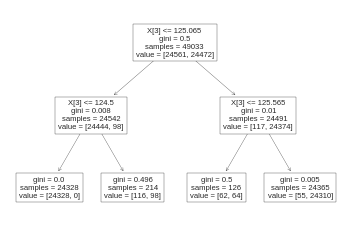

In [165]:
plot_tree(dtc_clf);

In [166]:
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

ten_fold = KFold(n_splits=10)
dtc_clf = DecisionTreeClassifier(max_depth=2, random_state=42)

for train_i, test_i in ten_fold.split(X):
  X_train, X_test = X.iloc[train_i,:], X.iloc[test_i,:]
  y_train, y_test = y.iloc[train_i], y.iloc[test_i]

  y_train = (y_train > 625.830539)
  y_test = (y_test > 625.830539)

  # dtc_clf.fit(X_train, y_train)
  # score = dtc_clf.score(X_train, y_train)
  # print("Training score: ", score) 

  y_pred = dtc_clf.fit(X_train, y_train).predict(X_test)
  print("Number of mislabeled points out of a total %d points : %d" % (X_test.shape[0], (y_test != y_pred).sum()))
  
  alpha = (y_test == y_pred).sum()
  beta = X_test.shape[0]
  print("Accuracy= ", (alpha / beta * 100))

  confusion_matrix(y_test, y_pred)
  matrix = confusion_matrix(y_test, y_pred)
  print("TP = ", matrix[0][0])
  print("FP = ", matrix[1][0])
  print("TN = ", matrix[1][1])
  print("FN = ", matrix[0][1])
  print("precision = ", matrix[0][0]/(matrix[0][0] + matrix[1][0]))
  print("recall = ", matrix[0][0]/(matrix[0][0] + matrix [0][1]))
  print("F-measure = ", (2 * (matrix[0][0]/matrix[0][0] + matrix[1][0]) * (matrix[0][0]/(matrix[0][0] + matrix [0][1])) / (matrix[0][0]/matrix[0][0] + matrix[1][0]) + (matrix[0][0]/(matrix[0][0] + matrix [0][1])) ))
  print("RoC Area = ", roc_auc_score(y_test, y_pred))





Number of mislabeled points out of a total 9807 points : 45
Accuracy=  99.54114408075864
TP =  4925
FP =  36
TN =  4837
FN =  9
precision =  0.9927433985083652
recall =  0.9981759221726794
F-measure =  2.994527766518038
RoC Area =  0.995394137979424
Number of mislabeled points out of a total 9807 points : 40
Accuracy=  99.59212807178545
TP =  4985
FP =  14
TN =  4782
FN =  26
precision =  0.9971994398879775
recall =  0.994811414887248
F-measure =  2.984434244661744
RoC Area =  0.9959461578189368
Number of mislabeled points out of a total 9807 points : 52
Accuracy=  99.4697664933211
TP =  4862
FP =  37
TN =  4893
FN =  15
precision =  0.9924474382527047
recall =  0.9969243387328276
F-measure =  2.990773016198483
RoC Area =  0.9947096338694564
Number of mislabeled points out of a total 9807 points : 57
Accuracy=  99.41878250229428
TP =  4842
FP =  19
TN =  4908
FN =  38
precision =  0.996091339230611
recall =  0.9922131147540983
F-measure =  2.976639344262295
RoC Area =  0.99417840637238

30% dataset score: 0.9961930659415363


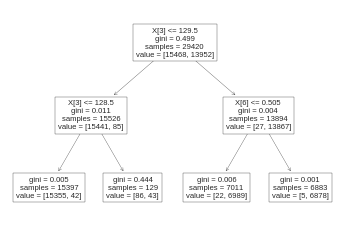

In [167]:
#Using 30% of the total dataset
thirtyTree = DecisionTreeClassifier(max_depth=2, random_state=42)
X_trainThirty, X_testThirty, y_trainThirty, y_testThirty = train_test_split(X, y, test_size = 0.7)
y_trainThirtyAboveMean = (y_trainThirty > 645.830539)
thirtyTree.fit(X_trainThirty, y_trainThirtyAboveMean)
thirtyScore = thirtyTree.score(X_trainThirty, y_trainThirtyAboveMean)
print("30% dataset score:", thirtyScore)
plot_tree(thirtyTree);


#Using 60% of the total dataset
sixtyTree = DecisionTreeClassifier(max_depth=2, random_state=42)
X_trainSixty, X_testSixty, y_trainSixty, y_testSixty = train_test_split(X, y, test_size = 0.4)
y_trainSixtyAboveMean = (y_trainSixty > 645.830539)
sixtyTree.fit(X_trainSixty, y_trainSixtyAboveMean)
sixtyScore = sixtyTree.score(X_trainSixty, y_trainSixtyAboveMean)


#Using 100% of the ttoal dataset
fullTree = DecisionTreeClassifier(max_depth=2, random_state=42)
fullTree.fit(X_train, y_train)
fullScore = fullTree.score(X_train, y_train)

60% dataset score: 0.9960740992522094


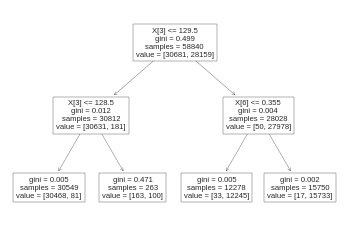

In [168]:
print("60% dataset score:", sixtyScore)
plot_tree(sixtyTree);

Full dataset score:  0.9956151979279261


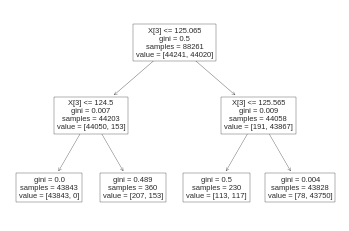

In [169]:
print("Full dataset score: ", score) 
plot_tree(fullTree);

30% = 99.66% accuracy  
60% = 99.64% accuracy  
100% = 99.61% accuracy  
  
As more data is used, accuracy goes down by an average of 0.01% for every 10% of data added. 

# Regression

In [186]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(X, y) #train linear regression on X and y
lin_reg.intercept_, lin_reg.coef_ # learning parameters 

(146.62506101332087,
 array([-5.99182493e-01,  1.14233313e+00, -1.81256850e-02,  4.99054839e+00,
         8.41773332e-03, -4.02790896e-04,  4.58836651e-02, -3.27381661e-02,
        -2.16446494e-03,  4.91399593e-04]))

In [203]:
lin_reg.predict(X)

array([ 964.41745154,  141.2777985 ,  620.22510085, ...,  844.87813741,
        989.48450045, 1029.24612197])

In [204]:
theta_best_svd, residuals, rank, s = np.linalg.lstsq(X, y, rcond=1e-6)
theta_best_svd # Least-squares solution

array([ 1.21662831e-01, -3.66627468e-01, -1.53097746e-02,  4.99055504e+00,
        8.16227212e-03, -4.17914509e-04,  5.10117430e-02, -3.17982518e-02,
       -2.45699659e-03,  5.48484569e-04])

In [210]:
eta = 0.1  # learning rate
n_iterations = 1000
m = 100      #batch size is 100 samples      

theta = np.random.randn(2,1)  # random initialization of the weights

X_b = bnb_data["lat"], bnb_data["long"]
#print(X_b)

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)# This is the gradient descent iteration  - m is for the batch version
    theta = theta - eta * gradients                # theta are the weights and updated acording to the gradient descent


theta

AttributeError: ignored

In [208]:
theta_path_bgd = []
def plot_gradient_descent(theta, eta, theta_path=None):
    m = len(X_b)
    plt.plot(X, y, "b.")
    n_iterations = 1000
    for iteration in range(n_iterations):
        if iteration < 10:
            y_predict = X_b.dot(theta)
            style = "b-" if iteration > 0 else "r--"
            plt.plot(X_new, y_predict, style)
        gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
        theta = theta - eta * gradients
        if theta_path is not None:
            theta_path.append(theta)
    plt.xlabel("$x_1$", fontsize=18)
    plt.axis([0, 2, 0, 15])
    plt.title(r"$\eta = {}$".format(eta), fontsize=16)

AttributeError: ignored

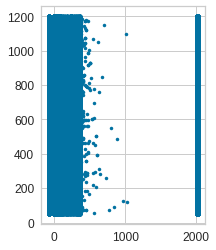

In [212]:
np.random.seed(42)
theta = np.random.randn(2,1)  # random initialization

plt.figure(figsize=(10,4))
plt.subplot(131); plot_gradient_descent(theta, eta=0.02)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.subplot(132); plot_gradient_descent(theta, eta=0.1, theta_path=theta_path_bgd)
plt.subplot(133); plot_gradient_descent(theta, eta=0.5)

plt.show()

In [217]:
#Logistic
from sklearn.linear_model import LogisticRegression
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

#kf = model_selection.KFold(n_splits=10, random_state=None)
log_reg = LogisticRegression(solver = 'lbfgs', random_state = 42)
log_reg.fit(x_trainTREE, y_trainTREE_above_mean)
#print("Avg accuracy: {}".format(result.mean()))




/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(random_state=42)

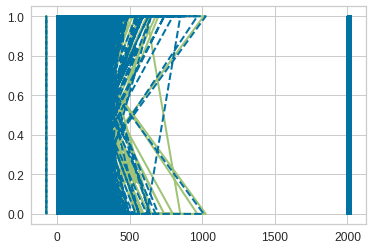

In [222]:
X_new = np.linspace(0, 3, 1000).reshape(-1, 1)
y_proba = log_reg.predict_proba(X) # estimated probability computed by the model, we use one feature (the petal width)

plt.plot(X, y_proba[:, 1], "g-", linewidth=2) # green curve plots estimated  probability of Iris-virginica class
plt.plot(X, y_proba[:, 0], "b--", linewidth=2) # blue dotted line computes estimated probability of NOT Iris-virginica class